In [1]:
# Imports
import geopandas as gpd
import numpy as np
import pandas as pd
import os 
import requests
import json
import datetime
import time
import random

# DATA PULL -------------------------------------------

### Census

In [2]:
k = "5e27dc113ca0300dabe2cbb8018489d6fcaf59fa"
URL = f"https://api.census.gov/data/2017/ecnlocmfg?get=NAME,NAICS2017_LABEL,ESTAB&for=county:011&in=state:49&NAICS2017&key={k}"
response = requests.get(URL)
response.json()

### Tract Centers - Geopandas
I may want to add sensors nearby and weights

In [26]:
geojson_gdf = gpd.read_file('../static/data/converted_geojson_data.geojson')

#geojson_gdf['centroid'] = geojson_gdf.geometry.centroid

In [27]:
geojson_gdf.columns

Index(['OBJECTID', 'GEOID', 'Source', 'geoname', 'Stusab', 'Countyname',
       'State', 'County', 'Tract', 'BLKGRP', 'Low', 'Lowmod', 'Lmmi',
       'Lowmoduniv', 'Lowmod_pct', 'uclowmod', 'ucLowmod_p', 'MOE_LOWMOD_PCT',
       'MOE_UCLOWMOD_PCT', 'Shape__Area', 'Shape__Length', 'category',
       'geometry'],
      dtype='object')

In [13]:
geojson_gdf = geojson_gdf[['OBJECTID', 'GEOID','Countyname','Tract','Low','Lowmod','Lowmod_pct','centroid']]


In [21]:
# Function to categorize based on 'Lowmod_pct'
def categorize(lowmod_pct):
    if lowmod_pct > 0.75:
        return 'red'
    elif lowmod_pct > 0.5:
        return 'orange'
    elif lowmod_pct > 0.25:
        return 'green'
    else:
        return 'blue'

# Apply categorization
geojson_gdf['category'] = geojson_gdf['Lowmod_pct'].apply(categorize)





In [17]:
geojson_gdf.rename(columns = {'Countyname':'county'},inplace=True)
geojson_gdf['latitude'] = geojson_gdf['centroid'].apply(lambda geom: geom.y)
geojson_gdf['longitude'] = geojson_gdf['centroid'].apply(lambda geom: geom.x)

In [23]:
geojson_gdf.to_file('../static/data/centroids_data.geojson', driver='GeoJSON')

## Salt Lake County City Assets
Matched with tract centers
https://gis-slcgov.opendata.arcgis.com/


#### Traffic Lights

In [38]:
geojson_gdf = gpd.read_file('../static/data/converted_geojson_data.geojson')


url_intersection = 'Signalized_Intersection.geojson'
geojson_int = gpd.read_file(f'../static/data/ml/{url_intersection}')


In [39]:
geojson_int

,CARTID,OBJECTID,Ownership,Type,geometry
0,1,505154,Salt Lake City,Full Signal,"POLYGON ((-112.02506 40.77663, -112.02511 40.7..."
1,2,505155,Salt Lake City,Full Signal,"POLYGON ((-112.00572 40.77381, -112.00577 40.7..."
2,3,505156,Salt Lake City,Full Signal,"POLYGON ((-111.95820 40.76835, -111.95824 40.7..."
3,5,505157,Salt Lake City,Full Signal,"POLYGON ((-111.95315 40.77054, -111.95320 40.7..."
4,6,505158,Salt Lake City,Full Signal,"POLYGON ((-111.94696 40.77181, -111.94700 40.7..."
...,...,...,...,...,...
384,1911,505538,Airport,Full Signal,"POLYGON ((-111.98627 40.77368, -111.98631 40.7..."
385,1912,505539,Airport,Full Signal,"POLYGON ((-111.98442 40.78430, -111.98446 40.7..."
386,1913,505540,Airport,Full Signal,"POLYGON ((-111.98532 40.78422, -111.98536 40.7..."
387,1914,505541,Salt Lake City,HAWK,"POLYGON ((-111.89972 40.73681, -111.89976 40.7..."


In [215]:
if geojson_gdf.crs != geojson_int.crs:
    geojson_int = geojson_int.to_crs(geojson_gdf.crs)

# Step 2: Perform the spatial join
joined_geodata = gpd.sjoin(geojson_int, geojson_gdf, how="inner", op="within")

/Users/juliakauffmann/miniforge3/envs/capstonev/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


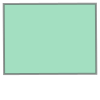

In [242]:
(joined_geodata['geometry'].values[130])

## Open-Mateo
https://open-meteo.com/en/docs/

In [3]:
# Must install the following

#!pip install openmeteo-requests
#!pip install requests-cache retry-requests numpy pandas

In [121]:
# Get Sensor lat and lon for Weather readings
dfx = pd.read_csv("../static/data/slc_daily_pm2.5_pm10_2016to2024.csv")
dfx = dfx.sort_values(['date'], ascending = False)

In [122]:
dfx=dfx.groupby(['sensor_id','latitude','longitude']).count().reset_index()[['latitude','longitude']]
dfx

,latitude,longitude
0,40.750816,-111.825290
1,41.224422,-111.968376
2,40.783870,-111.870140
3,40.595387,-111.807755
4,40.727630,-111.824425
...,...,...
217,40.593708,-111.895250
218,40.664610,-111.829270
219,40.567074,-111.988560
220,41.210533,-111.932014


In [155]:
wind_df = pd.DataFrame({})

In [156]:
#I really only needed wind for the actual sensor location for historic

# I want to modify this to just get. specific latitudes and longitudes instead of my grid method

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
start_date = datetime.datetime.strptime("2022-10-14", '%Y-%m-%d')
end_date = start_date + datetime.timedelta(days=10)

final_date = datetime.datetime.strptime("2024-03-10", '%Y-%m-%d')

i=0

while start_date < final_date:
    print(start_date)
    for i in range(0,222,37):

        url = "https://archive-api.open-meteo.com/v1/archive"

        params = {
            "latitude": list(dfx.iloc[i:i+36].latitude),
            "longitude": list(dfx.iloc[i:i+36].longitude),
            "start_date": datetime.datetime.strftime(start_date, '%Y-%m-%d'),
            "end_date": datetime.datetime.strftime(end_date, '%Y-%m-%d'),
            "daily": ["wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant",\
                     'weather_code','temperature_2m_max','temperature_2m_min',\
                     'rain_sum','snowfall_sum','precipitation_hours'],
            "temperature_unit": "fahrenheit",
            "wind_speed_unit": "mph",
            "timezone": "America/Denver"
        }
        responses = requests.get(url, params=params)
        print(responses.status_code)

        temp_df_b = pd.DataFrame()
        for response in responses.json():
    
            temp_df = pd.DataFrame(response['daily'])
            temp_df['latitiude'] = response['latitude']
            temp_df['longitude'] = response['longitude']
            temp_df['elevation'] = response['elevation']
            temp_df.drop_duplicates(subset=['wind_speed_10m_max',\
                                            'wind_gusts_10m_max',\
                                            'wind_direction_10m_dominant',\
                                            'weather_code','temperature_2m_max','temperature_2m_min',\
                                            'rain_sum','snowfall_sum','precipitation_hours',\
                                            'time'], keep='first',inplace = True)

            temp_df_b = pd.concat([temp_df_b,temp_df],ignore_index=True)

        wind_df = pd.concat([wind_df,temp_df_b],ignore_index=True)
        time.sleep(8+random.random())
    
    time.sleep(25.9+random.random())
    start_date += datetime.timedelta(days=11)
    end_date = start_date + datetime.timedelta(days=10)
    

2022-10-14 00:00:00
200
200
200
200
200
200
2022-10-25 00:00:00
200
200
200
200
200
200
2022-11-05 00:00:00
200
200
200
200
200
200
2022-11-16 00:00:00
200
200
200
200
200
200
2022-11-27 00:00:00
200
200
200
200
200
200
2022-12-08 00:00:00
200
200
200
200
200
200
2022-12-19 00:00:00
200
200
200
200
200
200
2022-12-30 00:00:00
200
200
200
200
200
200
2023-01-10 00:00:00
200
200
200
200
200
200
2023-01-21 00:00:00
200
200
200
200
200
200
2023-02-01 00:00:00
200
200
200
200
200
200
2023-02-12 00:00:00
200
200
200
200
200
200
2023-02-23 00:00:00
200
200
200
200
200
200
2023-03-06 00:00:00
200
200
200
200
200
200
2023-03-17 00:00:00
200
200
200
200
200
200
2023-03-28 00:00:00
200
200
200
200
200
200
2023-04-08 00:00:00
200
200
200
200
200
200
2023-04-19 00:00:00
200
200
200
200
200
200
2023-04-30 00:00:00
200
200
200
200
200
200
2023-05-11 00:00:00
200
200
200
200
200
200
2023-05-22 00:00:00
200
200
200
200
200
200
2023-06-02 00:00:00
200
200
200
200
200
200
2023-06-13 00:00:00
200
200
200


In [164]:
#df_wind_2021_2023 = pd.concat([wind_df_A_2020,wind_df_B_2021,wind_df_C_2021,wind_df_E_2022])

In [165]:
df_wind_2021_2023.head()

,time,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,weather_code,temperature_2m_max,temperature_2m_min,rain_sum,snowfall_sum,precipitation_hours,latitiude,longitude,elevation
0,2021-01-01,4.1,12.3,85,3,29.4,12.5,0.0,0.00,0.0,40.738136,-111.82979,1470.0
1,2021-01-02,6.4,14.8,121,71,35.0,13.3,0.0,0.07,1.0,40.738136,-111.82979,1470.0
2,2021-01-03,9.9,21.7,148,73,35.5,20.5,0.0,1.89,8.0,40.738136,-111.82979,1470.0
3,2021-01-04,6.5,22.4,139,3,41.9,24.0,0.0,0.00,0.0,40.738136,-111.82979,1470.0
4,2021-01-05,7.1,21.7,76,73,40.2,19.7,0.6,1.75,9.0,40.738136,-111.82979,1470.0


In [166]:
#wind_df.drop_duplicates(inplace=True)
print(f'length before drop: {len(df_wind_2021_2023)}')
df_wind_2021_2023.drop_duplicates(keep='first',inplace = True)
print(f'length before drop: {len(df_wind_2021_2023)}')

length before drop: 292248
length before drop: 227760


In [167]:
df_wind_2021_2023.rename(columns={'latitiude':'latitude'}, inplace=True)
df_wind_2021_2023.sort_values(['time','latitude','longitude'],inplace=True)

In [172]:
df_wind_2021_2023='' #clear
wind_df_A_2020 = ''
wind_df_B_2021 = ''
wind_df_C_2021 =''
wind_df_E_2022 = ''

#df_wind_2021_2023.to_csv('../static/data/df_wind_2021_2023.csv')

# LOAD DATA --------------------------------------------------

### Weather Data

In [30]:
df_wind = pd.read_csv('../static/data/df_wind_2021_2023.csv') 
df_wind.head()

,Unnamed: 0,time,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,weather_code,temperature_2m_max,temperature_2m_min,rain_sum,snowfall_sum,precipitation_hours,latitude,longitude,elevation
0,143,2021-01-01,7.5,17.7,110,3,28.9,15.8,0.0,0.0,0.0,40.527240,-111.864395,1488.0
1,506,2021-01-01,8.7,12.8,301,1,29.9,12.9,0.0,0.0,0.0,40.597538,-112.022630,1519.0
2,1628,2021-01-01,8.7,12.8,301,1,30.6,13.6,0.0,0.0,0.0,40.597538,-112.022630,1454.0
3,1749,2021-01-01,8.7,12.8,301,1,31.0,14.0,0.0,0.0,0.0,40.597538,-112.022630,1419.0
4,2310,2021-01-01,8.7,12.8,301,1,30.5,13.5,0.0,0.0,0.0,40.597538,-112.022630,1468.0


### Purple Air

In [34]:
df_purple = pd.read_csv("../static/data/slc_daily_pm2.5_pm10_2016to2024.csv")
df_purple = df_purple.sort_values(['date'], ascending = False)

In [35]:
df_purple = df_purple[['sensor_id','latitude','longitude','date','altitude','pm2.5_atm','pm10.0_atm']]
df_purple.rename(columns = {'pm2.5_atm':'pm2','pm10.0_atm':'pm10'},inplace=True)
df_purple['date'] = pd.to_datetime(df_purple['date'], format='%m/%d/%y')
df_purple.head()

,sensor_id,latitude,longitude,date,altitude,pm2,pm10
232809,83563,41.153950,-111.937020,2023-09-09,4806,2.0930,2.3085
243366,122011,40.639800,-111.822510,2023-09-09,4499,0.4095,0.5130
241621,114467,41.063160,-111.903320,2023-09-09,5104,0.1460,0.2130
225969,44157,40.574078,-111.958800,2023-09-09,4533,10.7160,12.9255
217892,30967,41.066500,-111.912445,2023-09-09,4774,3.4305,3.9045


### Centroids AI Sensor Locations

In [37]:
centroid_gdf = gpd.read_file('../static/data/centroids_data.geojson')
centroid_gdf.head()

,OBJECTID,GEOID,county,Tract,Low,Lowmod,Lowmod_pct,category,geometry
0,199060,490111251021,Davis County,125102,120,340,0.1833,blue,POINT (-111.88081 41.08032)
1,199061,490111251022,Davis County,125102,245,490,0.1892,blue,POINT (-111.88004 41.04248)
2,199062,490111251031,Davis County,125103,370,850,0.3131,green,POINT (-111.95631 41.13919)
3,199063,490111251032,Davis County,125103,430,1000,0.4264,green,POINT (-111.94339 41.11548)
4,199064,490111251041,Davis County,125104,165,475,0.1967,blue,POINT (-111.91575 41.12877)


### Tract Shape and Data

In [36]:
geojson_gdf = gpd.read_file('../static/data/converted_geojson_data.geojson')
geojson_gdf.head()

,OBJECTID,GEOID,Source,geoname,Stusab,Countyname,State,County,Tract,BLKGRP,...,Lowmoduniv,Lowmod_pct,uclowmod,ucLowmod_p,MOE_LOWMOD_PCT,MOE_UCLOWMOD_PCT,Shape__Area,Shape__Length,category,geometry
0,199060,490111251021,2015ACS,"Block Group 1, Census Tract 1251.02, Davis Cou...",UT,Davis County,49,011,125102,1,...,1855,0.1833,,0.0,+/-8.84,,0.003127,0.247074,blue,"POLYGON ((-111.91096 41.07743, -111.91094 41.0..."
1,199061,490111251022,2015ACS,"Block Group 2, Census Tract 1251.02, Davis Cou...",UT,Davis County,49,011,125102,2,...,2590,0.1892,,0.0,+/-10.35,,0.001493,0.249462,blue,"POLYGON ((-111.91272 41.01196, -111.91226 41.0..."
2,199062,490111251031,2015ACS,"Block Group 1, Census Tract 1251.03, Davis Cou...",UT,Davis County,49,011,125103,1,...,2715,0.3131,,0.0,+/-13.44,,0.000760,0.202563,green,"POLYGON ((-111.99941 41.15267, -111.99930 41.1..."
3,199063,490111251032,2015ACS,"Block Group 2, Census Tract 1251.03, Davis Cou...",UT,Davis County,49,011,125103,2,...,2345,0.4264,,0.0,+/-12.24,,0.000688,0.231558,green,"POLYGON ((-111.99137 41.14869, -111.99112 41.1..."
4,199064,490111251041,2015ACS,"Block Group 1, Census Tract 1251.04, Davis Cou...",UT,Davis County,49,011,125104,1,...,2415,0.1967,,0.0,+/-7.95,,0.000355,0.111711,blue,"POLYGON ((-111.92997 41.13249, -111.92911 41.1..."


### Census Tract Density ### Proxy for space

# MODEL - TENSORFLOW -------------------------------

In [29]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

In [257]:
# set randomizer seeds

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
import matplotlib.pyplot as plt

In [268]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

input_shape = (1,)


inputs = Input(shape=input_shape)


dense_layer = Dense(64, activation='relu')(inputs)


model = Model(inputs=inputs, outputs=dense_layer)


model.compile(optimizer='adam',
              loss='mean_squared_error', 
              metrics=['accuracy']) 

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128 (512.00 B)

 Trainable params: 128 (512.00 B)

 Non-trainable params: 0 (0.00 B)

In [318]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# random data
num_samples = 1000
data = np.random.normal(loc=8.0, scale=4.0, size=num_samples)


target = np.mean(data) * np.ones((num_samples,))

# single dense layer
inputs = Input(shape=(1,))
outputs = Dense(1, use_bias=True)(inputs) 
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss='mean_squared_error')



# reshae data
X = data.reshape(-1, 1)
Y = target.reshape(-1, 1)

# train model

model.fit(X, Y, epochs=10, batch_size=32) 


weights = model.layers[1].get_weights()[0]
bias = model.layers[1].get_weights()[1]

print(f"Weights: {weights.flatten()}, Bias: {bias}")


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 53.7870
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 9.6236
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 7.3836
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 5.6650
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 4.3464
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 3.3348
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 2.5586
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 1.9630
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 1.5061
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 1.1556
Weights: [0.2664068], Bias: [5.725777]


In [319]:
model.save('../static/data/test_model.h5')


In [28]:
keras.saving.save_model(model, '../static/data/test_model.keras')